In [1]:
import pandas as pd
import numpy as np

from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, f1_score

import joblib
import matplotlib.pyplot as plt


In [5]:
train_df = pd.read_csv("../train.csv")
test_df  = pd.read_csv("../test.csv")

X_ref = train_df.drop(columns=["default"])
y_ref = train_df["default"]

X_holdout = test_df.drop(columns=["default"])
y_holdout = test_df["default"]

model = joblib.load("../Notebooks/credit_risk_logistic_model.joblib")


Create “production batches”

Because we don’t have real timestamps, we simulate 5 batches from holdout data and inject drift.

In [8]:
#2.1 Helper: make batches
def make_batches(X, y, n_batches=5, random_state=42):
    rng = np.random.default_rng(random_state)
    idx = rng.permutation(len(X))
    splits = np.array_split(idx, n_batches)
    return [(X.iloc[s].copy(), y.iloc[s].copy()) for s in splits]

batches = make_batches(X_holdout, y_holdout, n_batches=5)


In [12]:
# 2.2 Drift injection
def inject_drift(X_batch, drift_level=0.0, random_state=0):
    """
    drift_level: 0.0 (no drift) to ~1.0 (strong drift)
    We apply:
      - utilization shift upward
      - limit_bal shift downward
      - more payment delays
    """
    rng = np.random.default_rng(random_state)

    X = X_batch.copy()

    # Shift utilization upward (population shift)
    X["UTILIZATION_RATE"] = np.clip(
        X["UTILIZATION_RATE"] + rng.normal(loc=0.10*drift_level, scale=0.03, size=len(X)),
        0, 1
    )

    # Shift credit limit downward slightly
    X["LIMIT_BAL"] = np.clip(
        X["LIMIT_BAL"] * (1 - 0.08*drift_level) + rng.normal(0, 5000, size=len(X)),
        20000, 500000
    )

    # Increase delays
    X["PAY_DELAY_MONTHS"] = np.clip(
        X["PAY_DELAY_MONTHS"] + rng.poisson(lam=0.6*drift_level, size=len(X)),
        0, None
    )

    return X

In [14]:
prod_batches = []
for i, (X_b, y_b) in enumerate(batches, start=1):
    drift_level = (i-1) / (len(batches)-1)  # 0 → 1
    X_drifted = inject_drift(X_b, drift_level=drift_level, random_state=100+i)
    prod_batches.append((f"batch_{i}", X_drifted, y_b, drift_level))

3.1 PSI (Population Stability Index)

Intuition: compares histograms of a feature in reference vs batch.
Rules of thumb:

PSI < 0.1: low drift

0.1–0.25: moderate drift

0.25: high drift

In [17]:
def psi(expected, actual, bins=10, eps=1e-6):
    expected = np.array(expected)
    actual   = np.array(actual)

    breakpoints = np.linspace(0, 100, bins + 1)
    cuts = np.percentile(expected, breakpoints)

    # avoid duplicate bin edges
    cuts = np.unique(cuts)
    if len(cuts) <= 2:
        return 0.0  # feature has near-constant values

    exp_counts, _ = np.histogram(expected, bins=cuts)
    act_counts, _ = np.histogram(actual, bins=cuts)

    exp_perc = exp_counts / max(exp_counts.sum(), 1)
    act_perc = act_counts / max(act_counts.sum(), 1)

    exp_perc = np.clip(exp_perc, eps, 1)
    act_perc = np.clip(act_perc, eps, 1)

    return np.sum((act_perc - exp_perc) * np.log(act_perc / exp_perc))


3.2 KS Test

Intuition: measures whether two distributions differ.
You’ll store p-values:

small p-value (e.g., < 0.05) suggests the distributions differ

In [20]:
def ks_pvalue(expected, actual):
    return ks_2samp(expected, actual).pvalue


In [22]:
numeric_features = ["LIMIT_BAL", "AGE", "UTILIZATION_RATE", "PAY_DELAY_MONTHS"]


4.For each batch: compute drift + performance

In [25]:
results = []

for batch_name, X_b, y_b, drift_level in prod_batches:
    # drift metrics per numeric feature
    psi_scores = {f: psi(X_ref[f], X_b[f]) for f in numeric_features}
    ks_pvals   = {f: ks_pvalue(X_ref[f], X_b[f]) for f in numeric_features}

    # prediction + performance
    proba = model.predict_proba(X_b)[:, 1]
    auc = roc_auc_score(y_b, proba)
    f1  = f1_score(y_b, (proba >= 0.5).astype(int))

    # prediction drift summary
    proba_mean = float(np.mean(proba))
    proba_p95  = float(np.percentile(proba, 95))

    results.append({
        "batch": batch_name,
        "drift_level_simulated": drift_level,
        "auc": auc,
        "f1": f1,
        "proba_mean": proba_mean,
        "proba_p95": proba_p95,
        **{f"psi_{k}": v for k, v in psi_scores.items()},
        **{f"ks_p_{k}": v for k, v in ks_pvals.items()},
    })

monitor_df = pd.DataFrame(results)
monitor_df


,batch,drift_level_simulated,auc,f1,proba_mean,proba_p95,psi_LIMIT_BAL,psi_AGE,psi_UTILIZATION_RATE,psi_PAY_DELAY_MONTHS,ks_p_LIMIT_BAL,ks_p_AGE,ks_p_UTILIZATION_RATE,ks_p_PAY_DELAY_MONTHS
0,batch_1,0.00,0.667643,0.644928,0.512101,0.806722,0.033315,0.028359,0.019426,0.009002,0.251389,0.388052,8.518368e-01,0.959247
1,batch_2,0.25,0.697183,0.680702,0.540592,0.833568,0.033633,0.026132,0.070749,0.034218,0.555434,0.868273,5.485108e-03,0.066693
2,batch_3,0.50,0.703924,0.676157,0.570324,0.850827,0.149703,0.044652,0.155637,0.053211,0.005485,0.851837,3.894066e-03,0.048066
3,batch_4,0.75,0.677217,0.686084,0.590997,0.859007,0.097635,0.078083,0.266742,0.102859,0.000549,0.003894,8.878012e-08,0.002026
4,batch_5,1.00,0.727438,0.747774,0.637395,0.892809,0.103371,0.018158,0.634016,0.146809,0.001158,0.981583,3.433545e-17,0.000005


5️ Plot: performance decay over batches

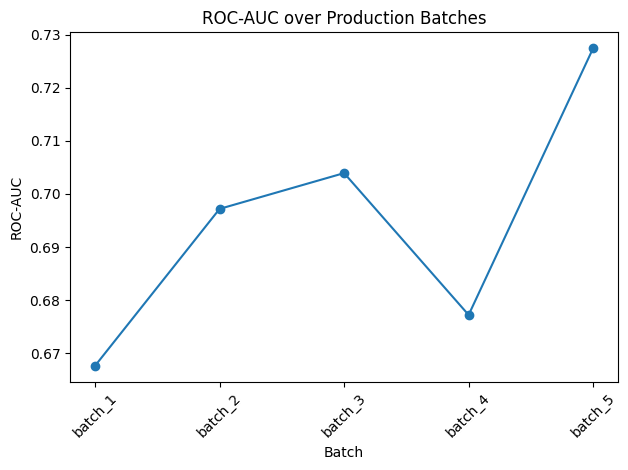

In [29]:
plt.figure()
plt.plot(monitor_df["batch"], monitor_df["auc"], marker="o")
plt.title("ROC-AUC over Production Batches")
plt.xlabel("Batch")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

6️ Plot: drift summary (PSI per feature)

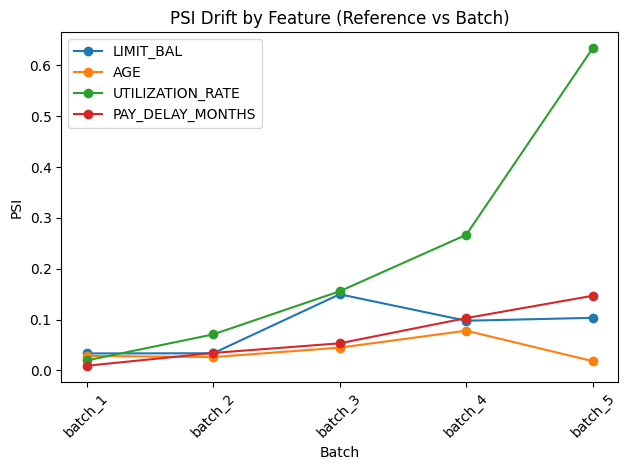

In [31]:
plt.figure()
for f in numeric_features:
    plt.plot(monitor_df["batch"], monitor_df[f"psi_{f}"], marker="o", label=f)

plt.title("PSI Drift by Feature (Reference vs Batch)")
plt.xlabel("Batch")
plt.ylabel("PSI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


️7 Auto-generate a Model Risk Report (Markdown)

In [37]:
# 7,1 Severity rules
def psi_severity(v):
    if v < 0.10: return "low"
    if v < 0.25: return "moderate"
    return "high"

In [41]:
# 7.2 
report_lines = []
report_lines.append("# Model Risk Report – Credit Risk Monitoring\n")
report_lines.append("## Summary\n")

latest = monitor_df.iloc[-1]
report_lines.append(f"- Latest batch: **{latest['batch']}**\n")
report_lines.append(f"- ROC-AUC: **{latest['auc']:.3f}** | F1: **{latest['f1']:.3f}**\n")
report_lines.append(f"- Mean predicted risk: **{latest['proba_mean']:.3f}** | 95th pct risk: **{latest['proba_p95']:.3f}**\n")

report_lines.append("\n## Drift Findings (PSI)\n")

for f in numeric_features:
    v = float(latest[f"psi_{f}"])
    report_lines.append(f"- **{f}**: PSI={v:.3f} → **{psi_severity(v)}**\n")

report_lines.append("\n## Statistical Shift (KS test p-values)\n")
for f in numeric_features:
    p = float(latest[f"ks_p_{f}"])
    report_lines.append(f"- **{f}**: p-value={p:.4f}\n")

# action recommendation
high_drift = any(float(latest[f"psi_{f}"]) >= 0.25 for f in numeric_features)
auc_drop = latest["auc"] < monitor_df["auc"].iloc[0] - 0.05  # drop > 0.05

report_lines.append("\n## Recommended Action\n")
if high_drift and auc_drop:
    report_lines.append("- **Retrain candidate**: high drift + meaningful performance drop detected.\n")
elif high_drift:
    report_lines.append("- **Investigate & monitor**: high drift detected, but performance impact unclear.\n")
elif auc_drop:
    report_lines.append("- **Investigate labels / threshold**: performance dropped without strong drift signals.\n")
else:
    report_lines.append("- **Continue monitoring**: no major drift or decay detected.\n")

report_path = "../model_risk_report.md"
with open(report_path, "w", encoding="utf-8") as f:
    f.writelines(report_lines)

report_path


'../model_risk_report.md'